In [1]:
import pandas as pd

import numpy as np

from sklearn import datasets, model_selection, neighbors
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score, accuracy_score

from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.ensemble import RandomForestClassifier

from seaborn import heatmap
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.colors import ListedColormap

# Mini-Project 2 in Introduction to Data Science
## by Patrik Runeberg


# Create Pandas DataFrame

In [2]:
dataframe = pd.read_csv("datasets_dataset.csv")



# Data Processing
### Remove data for "tourist" students that have got no total points after 8 weeks, since these data will contribute errors in the predictions.
### Remove the column with student IDs, and Week8_Total (since it is directly related to the final grade)
### Remove columns and rows where the average point is < 1, as these will give little value to the predictions


In [3]:
df= dataframe[dataframe.Week8_Total > 0]
df=df.drop(["ID","Week8_Total"],axis=1)
df=df.loc[(df.mean(axis=1) >= 1),(df.mean(axis=0) >= 1)]
df.head(10)


,Week2_Quiz1,Week3_MP1,Week3_PR1,Week5_MP2,Week5_PR2,Week7_MP3,Week7_PR3,Week4_Quiz2,Week6_Quiz3,Week1_Stat0,...,Week7_Stat1,Week7_Stat2,Week7_Stat3,Week8_Stat0,Week8_Stat1,Week8_Stat2,Week9_Stat0,Week9_Stat1,Week9_Stat2,Grade
0,5.00,15.0,5.0,16.09,5.00,21.88,5.0,5.00,5.0,0,...,0,1,0,5,4,0,8,6,1,4
1,3.33,15.0,5.0,17.83,5.00,22.27,5.0,4.00,5.0,8,...,9,0,8,5,2,0,25,3,2,4
2,1.67,13.0,5.0,15.22,5.00,27.05,2.5,5.00,5.0,4,...,4,0,0,8,2,0,9,0,1,3
3,2.50,14.0,5.0,10.00,5.00,31.02,5.0,3.13,5.0,12,...,4,5,4,10,0,0,7,6,0,3
4,0.00,15.0,5.0,12.17,4.93,15.91,5.0,4.67,5.0,6,...,4,3,6,8,5,1,5,3,1,2
5,3.33,14.0,5.0,14.78,5.00,15.51,5.0,4.67,4.5,12,...,9,0,3,12,0,0,7,2,0,3
7,5.00,15.0,5.0,20.00,5.00,35.00,5.0,4.71,5.0,19,...,9,3,3,21,12,1,15,0,1,5
8,0.00,13.0,5.0,20.00,5.00,34.60,5.0,2.71,0.0,0,...,4,0,0,14,0,0,12,2,0,4
9,5.00,12.0,5.0,12.17,5.00,24.66,5.0,4.67,5.0,3,...,5,2,2,6,0,0,23,9,5,3
11,3.33,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.0,17,...,0,0,0,0,0,0,9,0,10,0


# Random forest 
## The main task of this mini-project
### the processed data is split into 

In [4]:
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.metrics import plot_confusion_matrix
#Split data into train and test set
def separate_train_test(dataframe):
    train, test = model_selection.train_test_split(dataframe, test_size=0.3 )
    y = train.Grade.values
    return train, test, y

# Create a random forest classifier and fit the train set
def make_rf_classifier(train, dataframe, y):
    clf = RandomForestClassifier(n_jobs=2, random_state=0)
    features= dataframe.columns[:-1]
    clf.fit(train[features], y)
    return clf, features

# Compare the predicted grades with the actual grades in the test set   
def predict(test, clf, feature):
    predicted =clf.predict(test[feature])
    print("\033[1m"+"The predicted grades: ", predicted,"\nThe actual grades:    ", test["Grade"].values,"\n"+"\033[0m")
    print()
    
    heatmap(clf.predict_proba(test[feature]), cmap='flare')
    plt.title("Prediction probability heatmap:")
    plt.xlabel('Grades')
    plt.xticks([0.5,1.5,2.5,3.5,4.5],[0,2,3,4,5])
    plt.ylabel('Test samples')
    plt.show()

    # Create confusion matrix
    print("------------------------------")
    
    try:
        plot_confusion_matrix(clf, test[feature], test["Grade"].values)
        plt.title("Confusion matrix")
        plt.xlabel('Predicted Grades')
        plt.ylabel('True Grades')
        plt.show()
    except: # the above confusion_matrix visualization throws an error if the number of classes (grades)
            # in the test set is fewer then announced for the classifier (5). 
            # If this happenes, plot it anyways
        plt.title("Confusion matrix")
        plt.xlabel('Predicted Grades')
        plt.ylabel('True Grades')
        plt.show()
#Show the probability prediction for each predicted grade
# OBS! No student got a final grade of 1, so the 5 predicted classes are: 0,2,3,4, and 5
def pred_prob(test, clf,features):
    heatmap(clf.predict_proba(test[features]))
    plt.show()
    
def CV_tuning(train, test, features):
    import sklearn
    clf =sklearn.svm.SVC(probability=True).fit(train[features], train.Grade)
    clf.score(test[features], test.Grade.values)
    predicted=clf.predict(test[features])
    print("\033[1m"+"The predicted grades after 5-fold cross validation: ", predicted)
    predict(test, clf, features)
    scores = cross_val_score(clf, train[features], train.Grade, cv=4)
    print("\033[1m\nScore using 4-Fold Cross Validation: \033[0m")
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [5]:
#The function for random forest training, testing and visualization
def random_forest(datafr):
    train, test, y = separate_train_test(datafr)
    clf, feat = make_rf_classifier(train, datafr, y)
    predict(test, clf, feat)

    importance =pd.DataFrame(zip(train[feat], clf.feature_importances_),columns=["Feature", "Weight on grade"]).sort_values(by=["Weight on grade"],ascending=False).reset_index(drop=True)
    print("------------------------------")
    print("\033[1m" +"\nMost important features:\n\n"+ "\033[0m", importance.head(3))
    print("------------------------------")
    print("\033[1m" + "\nLeast important features:\n\n" + "\033[0m", importance.tail(3))
    print("------------------------------")
    print("\033[1m" + "\nThe accuracy score: \n" + "\033[0m")
    print(classification_report(test["Grade"].values, clf.predict(test[feat])))
  
    
    scores = cross_val_score(clf, train[feat], y, cv=4)
    print("\033[1m\nScore using 4-Fold Cross Validation: \033[0m")
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    

## Random forest using all features in the processed dataframe

The predicted grades:  [0 3 3 0 3 4 3 4 3 4 3 4 4 3 3 0 5 4 0 0 3] 
The actual grades:     [0 3 2 0 4 5 4 5 3 5 3 3 4 2 3 0 4 4 0 0 2] 




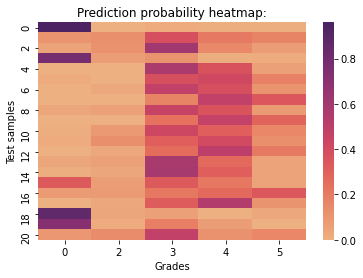

------------------------------


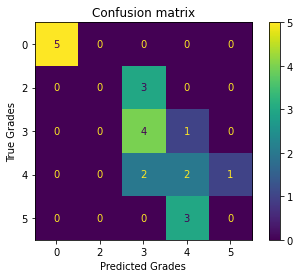

------------------------------

Most important features:

        Feature  Weight on grade
0    Week7_MP3         0.146263
1    Week5_MP2         0.102836
2  Week9_Stat0         0.062731
------------------------------

Least important features:

         Feature  Weight on grade
34  Week8_Stat2         0.004773
35  Week7_Stat2         0.004485
36    Week5_PR2         0.003788
------------------------------

The accuracy score: 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           2       0.00      0.00      0.00         3
           3       0.44      0.80      0.57         5
           4       0.33      0.40      0.36         5
           5       0.00      0.00      0.00         3

    accuracy                           0.52        21
   macro avg       0.36      0.44      0.39        21
weighted avg       0.42      0.52      0.46        21



/Users/patrikruneberg/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/patrikruneberg/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"



Score using 4-Fold Cross Validation: 
Accuracy: 0.57 (+/- 0.12)


In [6]:
random_forest(df)

## Futher processing the data set to get higher accuracy
### Random forest using only the features for the mini-projects, quizzez and peer-reviews

The predicted grades:  [5 4 5 0 0 3 3 4 4 5 5 3 3 4 5 3 4 5 3 4 4] 
The actual grades:     [5 4 5 0 0 4 3 4 3 5 4 3 4 4 5 3 4 5 3 4 4] 




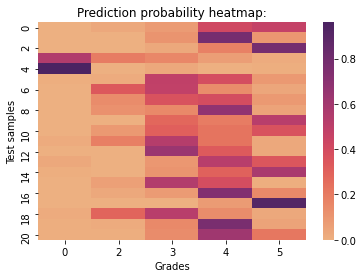

------------------------------


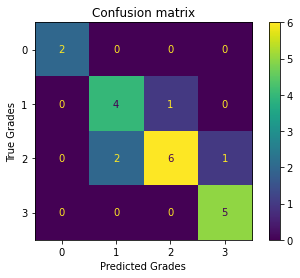

------------------------------

Most important features:

        Feature  Weight on grade
0    Week7_MP3         0.310198
1    Week5_MP2         0.188528
2  Week4_Quiz2         0.137977
------------------------------

Least important features:

        Feature  Weight on grade
6  Week6_Quiz3         0.050019
7    Week7_PR3         0.027504
8    Week3_PR1         0.021495
------------------------------

The accuracy score: 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           3       0.67      0.80      0.73         5
           4       0.86      0.67      0.75         9
           5       0.83      1.00      0.91         5

    accuracy                           0.81        21
   macro avg       0.84      0.87      0.85        21
weighted avg       0.82      0.81      0.81        21


Score using 4-Fold Cross Validation: 
Accuracy: 0.74 (+/- 0.13)


In [7]:
df2= df.copy()
for i in range(9,len(df.columns)-1):
    df2.drop(df2.columns[9],axis=1, inplace=True)
df2.columns[:-1]

random_forest(df2)